# AutoEncoder to initialize weights for supervised deep network

Before starting the code execution, make the following change: **Ambiente de execução -> Alterar o tipo de ambiente de execução -> GPU**

In [13]:
import numpy as np
from PIL import Image

from keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D, Conv2DTranspose, Dense
from tensorflow.keras.models import load_model
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

**Parameters definition:**

In [14]:
batchSize = 32
numberEpochs = 10
numberClasses = 10

**lowSampleDataset(X,Y)** function just reduces the number of examples so that the execution is faster in our example!

In [15]:
def lowSampleDataset(X, Y):
    perm = np.random.permutation(X.shape[0])
    X = X[perm[0 : (int)(X.shape[0] * (5/100))]]
    Y = Y[perm[0 : (int)(Y.shape[0] * (5/100))]]
    return X, Y

**Pre-processing:**

1.   Load CIFAR10 dataset
2.   Reduce the number of examples
1.   Change the resolution of the examples




In [16]:
print("Loading CIFAR10 images ...")
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

Xtrain, Ytrain = lowSampleDataset(Xtrain, Ytrain)
Xtest, Ytest = lowSampleDataset(Xtest, Ytest)

Ytrain = to_categorical(Ytrain)

print('\tTraining set shape: ', Xtrain.shape)
print('\tTesting set shape: ', Xtest.shape)

Loading CIFAR10 images ...
	Training set shape:  (2500, 32, 32, 3)
	Testing set shape:  (500, 32, 32, 3)


**Preparing the AutoEncoder:**

1.   Define the architecture structure
2.   Define the loss function and optimizer


In [17]:
print("Defining the AE ...")
input_img = Input(shape=(32, 32, 3,))

encoder = Conv2D(8, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(input_img)
encoder = Conv2D(8, kernel_size=(3,3), padding='valid', activation='relu')(encoder)
encoder = MaxPooling2D(pool_size=(2, 2))(encoder)
encoder = Flatten(name='code')(encoder)

decoder = Reshape((7,7,8))(encoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = Conv2DTranspose(8, kernel_size=(3,3), padding='valid', activation='relu')(decoder)
decoder = Conv2DTranspose(3, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(decoder)

autoencoder = Model(input_img, decoder)
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

Defining the AE ...
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         224       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
code (Flatten)               (None, 392)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 8)           0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14,

**AutoEncoder training:**

Training the AE ...
Epoch 1/10
79/79 [==============================] - 1s 5ms/step - loss: 10646.2549
Epoch 2/10
79/79 [==============================] - 0s 5ms/step - loss: 3604.7583
Epoch 3/10
79/79 [==============================] - 0s 5ms/step - loss: 1394.4449
Epoch 4/10
79/79 [==============================] - 0s 5ms/step - loss: 1166.9661
Epoch 5/10
79/79 [==============================] - 0s 5ms/step - loss: 1040.4517
Epoch 6/10
79/79 [==============================] - 0s 5ms/step - loss: 912.2008
Epoch 7/10
79/79 [==============================] - 0s 5ms/step - loss: 836.9224
Epoch 8/10
79/79 [==============================] - 0s 5ms/step - loss: 789.7896
Epoch 9/10
79/79 [==============================] - 0s 5ms/step - loss: 754.2484
Epoch 10/10
79/79 [==============================] - 0s 5ms/step - loss: 727.9525


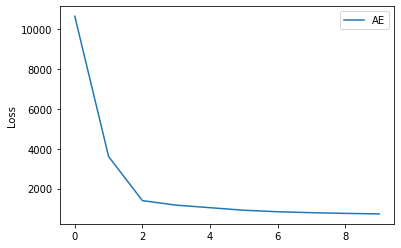

In [18]:
print("Training the AE ...")
historyAE = autoencoder.fit(x=Xtrain, y=Xtrain, batch_size=batchSize, epochs=numberEpochs, shuffle=True, verbose=1)

plt.plot(historyAE.history['loss'])
plt.ylabel('Loss')
plt.legend(['AE'], loc='upper right')
plt.show()

**Preparing the network for fine-tuning (Curriculum Learning using different tasks):**

1.   Load the pre-trained model
2.   Add the desired layers (the prediction layer must have the same number of classes from the target dataset)
1.   Define the loss function and optimizer

Loading the ResNet50-ImageNet model
	Adding new layers to the model ...
	Set fine-tuning configuration...
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         224       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
code (Flatten)               (None, 392)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 10)                3930      
Total params: 4,738

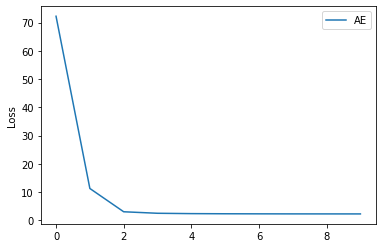

In [19]:
print("Loading the ResNet50-ImageNet model")

cnn = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(name="code").output)

print("\tAdding new layers to the model ...")
newTop = Sequential()
newTop.add(Dense(numberClasses, activation='softmax', name='fc1000', input_shape=cnn.output_shape[1:]))

print("\tSet fine-tuning configuration...")
cnn = Model(inputs=cnn.input, outputs=newTop(cnn.output))

#optimizer = SGD(lr=0.01, momentum=0.0001, decay=0.9)
optimizer = 'adam'
cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
cnn.summary()

print("Training the CNN ...")
historyCNN = cnn.fit(x=Xtrain, y=Ytrain, batch_size=batchSize, epochs=numberEpochs, shuffle=True, verbose=1)

plt.plot(historyCNN.history['loss'])
plt.ylabel('Loss')
plt.legend(['AE'], loc='upper right')
plt.show()